In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input/inme-veri-seti-stroke-dataset'):

data_dir_0 = '/kaggle/input/inme-veri-seti-stroke-dataset'
for root, dirs, files in os.walk(data_dir_0):
    print(root, len(files), 'files')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/inme-veri-seti-stroke-dataset 0 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ 2 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/İnme Yok 4551 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama 0 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama/DICOM 1093 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama/OVERLAY 1093 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama/PNG 1093 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum 0 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/DICOM 100 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/OVERLAY 100 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/MASKS 100 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/P

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/inme-veri-seti-stroke-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/inme-veri-seti-stroke-dataset


In [3]:
#check gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU:", gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Cant find GPU, use CPU.")

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'

In [6]:
import glob

hermorrhage_png = glob.glob(os.path.join(data_dir, 'Kanama/PNG/*.png'))
ischemia_png = glob.glob(os.path.join(data_dir, 'İskemi/PNG/*.png'))

images = []
labels = []

for img_path in hermorrhage_png:
    images.append(img_path)
    labels.append(1)  

for img_path in ischemia_png:
    images.append(img_path)
    labels.append(1) 

 

print(f"Count images: {len(images)}")
print(f"Count labels: {len(labels)}")

Count images: 2223
Count labels: 2223


## Classification Model 

In [10]:
# Download latest version
path = kagglehub.model_download("huongtraa/resnet18-f37072fd_classification/pyTorch/default")

print("Path to model files:", path)


Path to model files: /kaggle/input/resnet18-f37072fd_classification/pytorch/default/1


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths
base_path = "/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/"
ischemic_path = os.path.join(base_path, "İskemi/PNG")  # Updated to PNG
hemorrhagic_path = os.path.join(base_path, "Kanama/PNG")  # Updated to PNG
test_path = os.path.join(base_path, "YarısmaVeriSeti_2_Oturum/PNG")  # Updated to PNG

# Custom Dataset for PNG images
class PNGDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Read PNG image
        img = Image.open(image_path).convert("RGB")  # Ensure image is in RGB
        
        # Apply transformations if any (resize, normalize, etc.)
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Prepare the data (for demonstration purposes, assuming binary labels: 0 for ischemic, 1 for hemorrhagic)
image_paths = []
labels = []

# Add ischemic data (label 0 for ischemic)
for filename in os.listdir(ischemic_path):
    if filename.endswith(".png"):
        image_paths.append(os.path.join(ischemic_path, filename))
        labels.append(0)  # Ischemic -> 0

# Add hemorrhagic data (label 1 for hemorrhagic)
for filename in os.listdir(hemorrhagic_path):
    if filename.endswith(".png"):
        image_paths.append(os.path.join(hemorrhagic_path, filename))
        labels.append(1)  # Hemorrhagic -> 1

# Step 1: Split the data into train and validation sets (80% for train, 20% for validation)
train_files, val_files, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Step 2: Create Dataset and DataLoader for training, validation, and test sets
train_dataset = PNGDataset(image_paths=train_files, labels=train_labels, transform=transform)
val_dataset = PNGDataset(image_paths=val_files, labels=val_labels, transform=transform)
test_files_all = [os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith(".png")]
test_labels_all = [1] * len(test_files_all)  # Dummy labels, replace with actual labels if available
test_dataset = PNGDataset(image_paths=test_files_all, labels=test_labels_all, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Step 1: Load ResNet-18 model without pre-trained weights
model = models.resnet18(pretrained=False)

# Step 2: Load your custom pre-trained weights
model.load_state_dict(torch.load("/kaggle/input/resnet18-f37072fd_classification/pytorch/default/1/resnet18-f37072fd.pth"))

# Step 3: Modify the final fully connected layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

# Step 4: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Step 4: Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Training complete!")





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-7-8da236342496>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Epoch [1/10], Loss: 0.4485, Accuracy: 79.87%
Epoch [2/10], Loss: 0.1872, Accuracy: 93.08%
Epoch [3/10], Loss: 0.1590, Accuracy: 93.87%
Epoch [4/10], Loss: 0.0995, Accuracy: 96.23%
Epoch [5/10], Loss: 0.0894, Accuracy: 96.79%
Epoch [6/10], Loss: 0.0732, Accuracy: 97.24%
Epoch [7/10], Loss: 0.0553, Accuracy: 98.09%
Epoch [8/10], Loss: 0.0448, Accuracy: 98.31%
Epoch [9/10], Loss: 0.0399, Accuracy: 98.71%
Epoch [10/10], Loss: 0.0326, Accuracy: 98.93%
Training complete!


In [8]:
# Step 5: Evaluate the model on the validation set
model.eval()  # Set the model to evaluation mode
val_correct = 0
val_total = 0
val_loss = 0.0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy = 100 * val_correct / val_total
val_loss = val_loss / len(val_loader)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.1962, Validation Accuracy: 94.83%


In [9]:
import os
os.makedirs(f"/kaggle/working/models", exist_ok=True)

checkpoint_path = '/kaggle/working/models/classifier.pth'

torch.save(model.state_dict(), checkpoint_path)


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Validation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Validation Metrics:
Accuracy : 0.9483
Precision: 0.9845
Recall   : 0.9052
F1 Score : 0.9432


In [11]:
import matplotlib.pyplot as plt

def demo_classifier_model(image_path, model, device, mask_dir=None, show=True):
    """
    Demo classifier model on a single image.
    
    Args:
        image_path (str): Path to the test image (.png).
        model (torch.nn.Module): Trained classifier model.
        device (torch.device): CPU or GPU.
        mask_dir (str, optional): If provided, compares prediction with the ground truth mask.
        show (bool): Whether to display the image and mask.
    """
    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        pred_label = pred.item()

    print(f"\n📷 Image: {os.path.basename(image_path)}")
    print(f"🧠 Predicted Label: {'Kanama (1)' if pred_label == 1 else 'İskemi (0)'}")

    

In [13]:
image_path = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/PNG/10147.png'
demo_classifier_model(image_path, model, device)



📷 Image: 10147.png
🧠 Predicted Label: Kanama (1)


In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

def show_image_pil(image_path):
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Displayed Image: {os.path.basename(image_path)}')

    # Create legend handles
    legend_patches = [
        mpatches.Patch(color='green', label='Kanama'),
        mpatches.Patch(color='blue', label='Iskemi')
    ]
    plt.legend(handles=legend_patches, loc='upper right', frameon=False, labelcolor='white')

    plt.show()


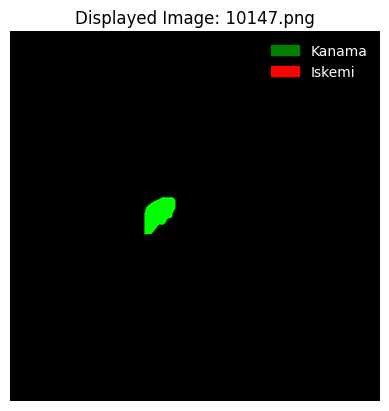

In [23]:
mask_path='/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/MASKS/10147.png'
show_image_pil(mask_path)